# Prithvi WxC Downscaling: Model Inference using TerraTorch
This notebook is a walk through to use a finetuned downscaling model to generate inferences using TerraTorch. We show how to initalize the model, load weights, and use the model for inference using TerraTorch.

Note to set up your environment by running the following cells. (We recommend to run this notebook in an empty pyton 3.11 environment)  
(e.g.,   
python3.11 -m venv .venv  
source .venv/bin/activate  
)  

We assume that you've cloned terratorch with:  
git clone https://github.com/IBM/terratorch.git  
And you run this notebook from terratorch/examples/notebooks  

In [ ]:
!pip install -U ../../.

In [ ]:
!pip install -U albumentations # fix until https://github.com/IBM/terratorch/issues/164 is solved

In [ ]:
!pip install git+https://github.com/NASA-IMPACT/Prithvi-WxC.git

In [ ]:
!pip install git+https://github.com/IBM/granite-wxc.git

In [ ]:
!pip install huggingface_hub

In [ ]:
import terratorch # this import is needed to initialize TT's factories
from lightning.pytorch import Trainer
import os
from granitewxc.utils.config import get_config
import torch
from terratorch.tasks.wxc_downscaling_task import WxCDownscalingTask
from terratorch.datamodules.merra2_downscale import Merra2DownscaleNonGeoDataModule
from granitewxc.utils.data import _get_transforms
from huggingface_hub import hf_hub_download, snapshot_download


## Load Config

We provide a configuration file that is used to configure data variables and model parameters. For inference most of these configurations are used as is. This includes the variables that the model is trained on, the variables that we downscale, the number of input timesteps, the amount of downscaling, the embedding dimensions for the model. When necessary, we will show which configurations need to be specified or changed outside of what is set in this file already.


In [7]:
config = get_config('../confs/granite-wxc-merra2-downscale-config.yaml')
config.download_path = './'

config.data.data_path_surface = os.path.join(config.download_path,'merra-2')
config.data.data_path_vertical = os.path.join(config.download_path, 'merra-2')
config.data.climatology_path_surface = os.path.join(config.download_path,'climatology')
config.data.climatology_path_vertical = os.path.join(config.download_path,'climatology')

config.model.input_scalers_surface_path = os.path.join(config.download_path,'climatology/musigma_surface.nc')
config.model.input_scalers_vertical_path = os.path.join(config.download_path,'climatology/musigma_vertical.nc')
config.model.output_scalers_surface_path = os.path.join(config.download_path,'climatology/anomaly_variance_surface.nc')
config.model.output_scalers_vertical_path = os.path.join(config.download_path,'climatology/anomaly_variance_vertical.nc')



## Download Model and Sample Data

We provide sample data from MERRA-2 dataset for a single day (2020 January 01), and weights for a finetuned downscaling model that we use in this notebook. These will be downloaded when you run the cell/s below

Before running the download set config.download_path to the directory where you want the model and sample data to be downloaded

Note: With config.download_path = './' the files are downloaded in the current working directory


In [ ]:
snapshot_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    allow_patterns="merra-2/MERRA2_sfc_2020010[1].nc",
    local_dir=".",
)

snapshot_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    allow_patterns="merra-2/MERRA_pres_2020010[1].nc",
    local_dir=".",
)


## Climatology

The PrithviWxC model was trained to calculate the output by producing a perturbation to the climatology at the target time. This mode of operation is set via the residual=climate option. This was chosen as climatology is typically a strong prior for long-range prediction. When using the residual=climate option, we have to provide the dataloader with the path of the climatology data.


In [ ]:
snapshot_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    allow_patterns="climatology/climate_surface_doy00[1]*.nc",
    local_dir=".",
)

snapshot_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    allow_patterns="climatology/climate_vertical_doy00[1]*.nc",
    local_dir=".",
)

hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"climatology/anomaly_variance_surface.nc",
    local_dir=".",
)

hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"climatology/anomaly_variance_vertical.nc",
    local_dir=".",
)

hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"climatology/musigma_surface.nc",
    local_dir=".",
)

hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"climatology/musigma_vertical.nc",
    local_dir=".",
)

In [ ]:
task = WxCDownscalingTask(model_args = {}, model_factory = 'WxCModelFactory', model_config=config, optimizer='AdamW', optimizer_hparams={'weight_decay': 0.05})

In [11]:
if torch.cuda.is_available():
    accelerator = 'gpu'
else:
    accelerator = 'cpu'

In [ ]:
hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"pytorch_model.bin",
    local_dir=".",
)

In [ ]:
task.model.load_state_dict(torch.load('./pytorch_model.bin', weights_only=True, map_location=torch.device(accelerator)))

In [13]:
datamodule = Merra2DownscaleNonGeoDataModule(
            data_path_surface = config.data.data_path_surface,
            data_path_vertical = config.data.data_path_vertical,
            climatology_path_surface = config.data.climatology_path_surface,
            climatology_path_vertical = config.data.climatology_path_vertical,
            input_surface_vars = config.data.input_surface_vars,
            input_static_surface_vars = config.data.input_static_surface_vars,
            input_vertical_vars = config.data.input_vertical_vars,
            input_levels = config.data.input_levels,
            n_input_timestamps = config.data.n_input_timestamps,
            output_vars=config.data.output_vars,
            time_range=('2020-01-01', '2020-01-02'),
            transforms=_get_transforms(config),)
datamodule.setup('predict')

In [ ]:
trainer = Trainer(
    accelerator=accelerator,
    max_epochs=1,
)

results = trainer.predict(model=task, datamodule=datamodule, return_predictions=True)

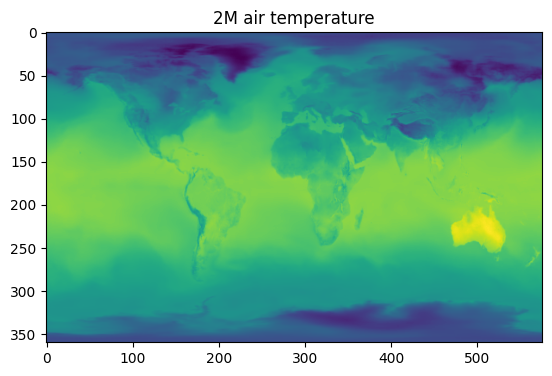

In [15]:
import matplotlib.pyplot as plt
import numpy as np

slice = results[0][0][0][0]
slice = torch.flip(slice, dims=[0])

plt.imshow(slice.numpy())
plt.title(f"2M air temperature")
plt.show()